# Examine ALOS2 Archive for Name_REY1NS_167aa.shp
### full catalog search (*no ability to download as of 10/2018)
https://satpf.jp/spf/?sb=search&sensor=ALOS-2_PALSAR-2&item=sb1_sar_palser2

### JAXA search requires old version of firefox that can use Microsoft silverlight (can download csv, kmz, shp)
https://auig2.jaxa.jp/ips/home?language=en_US


In [1]:
import pandas as pd
from pandas.plotting import table
import geopandas as gpd
import shapely
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
%matplotlib inline
#%qtconsole
plt.rcParams['font.size'] = 12

In [3]:
# Read everything 
# !! WARNING !! need to add comma at end of first row of heading labels
vectorFile = '/Users/scott/Documents/GitHub/snowex/snowex2019/ca-id-ut/Name_REY1NS_167aa.shp'
path = '/Users/scott/Documents/GitHub/snowex/snowex2019/ca-id-ut/Name_REY1NS_167aa-ALOS2.csv'
df = pd.read_csv(path)

In [4]:
# Convenient Summary!
df.groupby(["Orbit Direction", "Operation Mode", "OBS Path Number", "Centre Frame Number", "Beam No"])["Scene ID"].count()

Orbit Direction  Operation Mode  OBS Path Number  Centre Frame Number  Beam No
Ascending        SM2             64               850                  FP6-4       1
                                                  860                  FP6-4       1
                 SM3             64               850                  F2-5        7
                                                                       F2-6        5
                                                  860                  F2-5        7
                                                                       F2-6        5
                                 65               850                  F2-7        6
                 WD1             65               850                  W2          1
Descending       SM1             166              2750                 U2-9        1
                                 167              2740                 U2-6        1
                                                                       

In [5]:
# # NOTE that only same Operation Mode, OBS Path, Frame, Beam No, can be used for interferometry
# Select count > 2 from this groupby
order = ["Orbit Direction", "Operation Mode", "OBS Path Number", "Centre Frame Number", "Beam No"]
DF = df.groupby(order).filter(lambda x: len(x["Scene ID"]) >= 2)
# Reprint summary as groupby object
DF.groupby(order)["Scene ID"].count()

Orbit Direction  Operation Mode  OBS Path Number  Centre Frame Number  Beam No
Ascending        SM3             64               850                  F2-5        7
                                                                       F2-6        5
                                                  860                  F2-5        7
                                                                       F2-6        5
                                 65               850                  F2-7        6
Descending       WD1             167              2750                 W2         29
Name: Scene ID, dtype: int64

In [6]:
# NOTE: an alternative to the above!

# Select only paths with more than 10 coincidident acquisitions
#idx = df.groupby(["Operation Mode", "OBS Path Number"])["Scene ID"].count().gt(10) #RETURNS GROUP-BY
#idx = df.groupby(["Operation Mode", "OBS Path Number"])["Scene ID"].transform("count").gt(10) # RETURNS dataframe index
#DF = df[idx]

In [7]:
def make_footprints(df):
    """ extract shapely polygon footprint"""
    polys = []
    for i,row in df.iterrows():
        uly = row["Scene Upper Left Latitude"]
        ulx = row["Scene Upper Left Longitude"]
        ury = row["Scene Upper Right Latitude"] 
        urx = row["Scene Upper Right Longitude"]
        lly = row["Scene Lower Left Latitude"] 
        llx = row["Scene Lower Left Longitude"] 
        lry = row["Scene Lower Right Latitude"]
        lrx = row["Scene Lower Right Longitude"]
        coords = [ (ulx, uly), (urx, ury), (lrx, lry), (llx, lly), (ulx, uly)]
        polys.append(shapely.geometry.Polygon(np.array(coords).astype('f4')))

    return polys

In [8]:
# Add Polygon footprints
polys = make_footprints(DF)
gf = gpd.GeoDataFrame(DF, geometry=polys, crs={'init': 'epsg:4326'})

# Keep most relevant columns
cols = ["Scene ID", 
        "Operation Mode", 
        "Beam No",
        "OBS Path Number", 
        "Centre Frame Number", 
        "Observation Start Date", 
        "Orbit Direction",
        "Off Nadir Angle",
        "Polarization", 
        "geometry"] 
gf = gf.loc[:, cols]
gf.head()

,Scene ID,Operation Mode,Beam No,OBS Path Number,Centre Frame Number,Observation Start Date,Orbit Direction,Off Nadir Angle,Polarization,geometry
0,ALOS2015850850-140908,SM3,F2-7,65,850,2014/09/08 00:37:26,Ascending,36.2,HH+HV,"POLYGON ((-117.6190032958984 43.3129997253418,..."
1,ALOS2017180850-140917,SM3,F2-5,64,850,2014/09/17 00:30:20,Ascending,28.2,HH+HV,POLYGON ((-117.5199966430664 43.09199905395508...
2,ALOS2017180860-140917,SM3,F2-5,64,860,2014/09/17 00:30:20,Ascending,28.2,HH+HV,POLYGON ((-117.6510009765625 43.58499908447266...
3,ALOS2019250850-141001,SM3,F2-6,64,850,2014/10/01 00:30:12,Ascending,32.5,HH+HV,POLYGON ((-116.6999969482422 43.20500183105469...
4,ALOS2019250860-141001,SM3,F2-6,64,860,2014/10/01 00:30:12,Ascending,32.5,HH+HV,POLYGON ((-116.8239974975586 43.69900131225586...


In [9]:
# Rename to dinosar conventions
gf.rename(columns={"Observation Start Date" : 'sceneDate', 
                "OBS Path Number" : 'relativeOrbit', 
                "Orbit Direction" : 'flightDirection',
                "Scene ID" : 'sceneId',
                "Operation Mode" : 'opMode',
                "Beam No" : 'beamNo',
                "Centre Frame Number" : 'frame',
                "Off Nadir Angle" : 'incidence',
                "Polarization" : 'polarization'}, 
         inplace=True)
#gf.to_file('query-alos2-dinosar.geojson', driver='GeoJSON')

In [10]:
# Plot these frames on a map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import GoogleTiles

In [11]:
def plot_map(gf, snwe, vectorFile=None, zoom=8, title='Orbital Footprints', tableFrame=None):
    pad = 1
    S, N, W, E = snwe
    plot_CRS = ccrs.PlateCarree()
    geodetic_CRS = ccrs.Geodetic()
    x0, y0 = plot_CRS.transform_point(W-pad, S-pad, geodetic_CRS)
    x1, y1 = plot_CRS.transform_point(E+pad, N+pad, geodetic_CRS)

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150,
                           subplot_kw=dict(projection=plot_CRS))

    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))
    url = 'http://tile.stamen.com/terrain/{z}/{x}/{y}.png'
    tiler = GoogleTiles(url=url)
    # NOTE: going higher than zoom=8 is slow...
    ax.add_image(tiler, zoom)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='110m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='k', linestyle=':')
    ax.coastlines(resolution='10m', color='black', linewidth=2)
    ax.add_feature(cfeature.BORDERS)
    
    if type(tableFrame) == gpd.geodataframe.GeoDataFrame:
        table(ax, tableFrame, loc='top', zorder=10, fontsize=10,
          cellLoc='center', rowLoc='center',
          bbox=[0.1, 0.7, 0.6, 0.3]) 

    # Add region of interest polygon in specified
    if vectorFile:
        tmp = gpd.read_file(vectorFile)
        ax.add_geometries(tmp.geometry.values,
                          ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor='m',
                          lw=2,
                          linestyle='dashed')

    orbits = gf.relativeOrbit.unique()
    colors = plt.cm.jet(np.linspace(0, 1, orbits.size))

    for orbit, color in zip(orbits, colors):
        df = gf.query('relativeOrbit == @orbit')
        poly = df.geometry.cascaded_union

        if df.flightDirection.iloc[0] == 'ASCENDING':
            linestyle = '--'
            xpos, ypos = poly.centroid.x, poly.bounds[3]
        else:
            linestyle = '-'
            xpos, ypos = poly.centroid.x, poly.bounds[1]

        ax.add_geometries([poly],
                          ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor=color,
                          lw=2,
                          linestyle=linestyle)
        ax.text(xpos, ypos, orbit, color=color, fontsize=16, fontweight='bold',
                transform=geodetic_CRS)

    gl = ax.gridlines(plot_CRS, draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.title(title)
    plt.savefig('map.pdf', bbox_inches='tight')

In [12]:
def plot_timeline(gf, title='Acquisition Timeline'):
    """Plot dinosar inventory acquisitions as a timeline.

    Parameters
    ----------
    gf :  GeoDataFrame
        A geopandas GeoDataFrame

    """

    # Same colors as map
    orbits = gf.relativeOrbit.unique()
    colors = plt.cm.jet(np.linspace(0, 1, orbits.size))

    fig, ax = plt.subplots(figsize=(11, 8.5))
    plt.scatter(gf.timeStamp.values, gf.orbitCode.values,
                edgecolors=colors[gf.orbitCode.values], facecolors='None',
                cmap='jet', s=60, label='ALOS-2')

    plt.yticks(gf.orbitCode.unique(), gf.relativeOrbit.unique())

    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.legend(loc='lower right')
    plt.ylim(-1, orbits.size)
    plt.ylabel('Orbit Number')
    fig.autofmt_xdate()
    plt.title(title)
    plt.savefig('timeline.pdf', bbox_inches='tight')

In [13]:
def print_dates(GF):
    ''' print list of dates from dataframe'''
    tmp = GF.loc[:, ['sceneId','sceneDate']].reset_index(drop=True)
    tmp.loc[:, 'timeStamp'] = pd.to_datetime(tmp.sceneDate)
    tmp['date'] = tmp.sceneDate.str[:10]
    timeDeltas = tmp.timeStamp.diff()
    tmp['dt'] = timeDeltas.dt.days
    tmp.loc[0, 'dt'] = 0
    tmp['dt'] = tmp.dt.astype('i2')
    return tmp.loc[:, ['date','dt']]

In [14]:
gf.head()

,sceneId,opMode,beamNo,relativeOrbit,frame,sceneDate,flightDirection,incidence,polarization,geometry
0,ALOS2015850850-140908,SM3,F2-7,65,850,2014/09/08 00:37:26,Ascending,36.2,HH+HV,"POLYGON ((-117.6190032958984 43.3129997253418,..."
1,ALOS2017180850-140917,SM3,F2-5,64,850,2014/09/17 00:30:20,Ascending,28.2,HH+HV,POLYGON ((-117.5199966430664 43.09199905395508...
2,ALOS2017180860-140917,SM3,F2-5,64,860,2014/09/17 00:30:20,Ascending,28.2,HH+HV,POLYGON ((-117.6510009765625 43.58499908447266...
3,ALOS2019250850-141001,SM3,F2-6,64,850,2014/10/01 00:30:12,Ascending,32.5,HH+HV,POLYGON ((-116.6999969482422 43.20500183105469...
4,ALOS2019250860-141001,SM3,F2-6,64,860,2014/10/01 00:30:12,Ascending,32.5,HH+HV,POLYGON ((-116.8239974975586 43.69900131225586...


In [15]:
# Generate plots for all possible interferometric pairs (with dinosar naming scheme)
order = ["flightDirection", "opMode", "relativeOrbit", "frame", "beamNo"]
GF = gf.groupby(order).filter(lambda x: len(x["sceneId"]) > 2)
# Reprint summary as groupby object

w, s, e, n = GF.geometry.cascaded_union.bounds
snwe = [s, n, w, e]

GF.groupby(order)["sceneId"].count()

flightDirection  opMode  relativeOrbit  frame  beamNo
Ascending        SM3     64             850    F2-5       7
                                               F2-6       5
                                        860    F2-5       7
                                               F2-6       5
                         65             850    F2-7       6
Descending       WD1     167            2750   W2        29
Name: sceneId, dtype: int64

In [16]:
GB = GF.groupby(order)["sceneId"]
print(GB.groups)

{('Ascending', 'SM3', 64, 850, 'F2-5'): Int64Index([1, 9, 16, 29, 58, 63, 70], dtype='int64'), ('Ascending', 'SM3', 64, 850, 'F2-6'): Int64Index([3, 18, 31, 61, 65], dtype='int64'), ('Ascending', 'SM3', 64, 860, 'F2-5'): Int64Index([2, 10, 17, 30, 59, 64, 71], dtype='int64'), ('Ascending', 'SM3', 64, 860, 'F2-6'): Int64Index([4, 19, 32, 62, 66], dtype='int64'), ('Ascending', 'SM3', 65, 850, 'F2-7'): Int64Index([0, 8, 25, 50, 67, 69], dtype='int64'), ('Descending', 'WD1', 167, 2750, 'W2'): Int64Index([ 5,  6,  7, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 26, 28, 33, 38,
            40, 41, 44, 45, 46, 47, 48, 49, 54, 57, 60, 68],
           dtype='int64')}


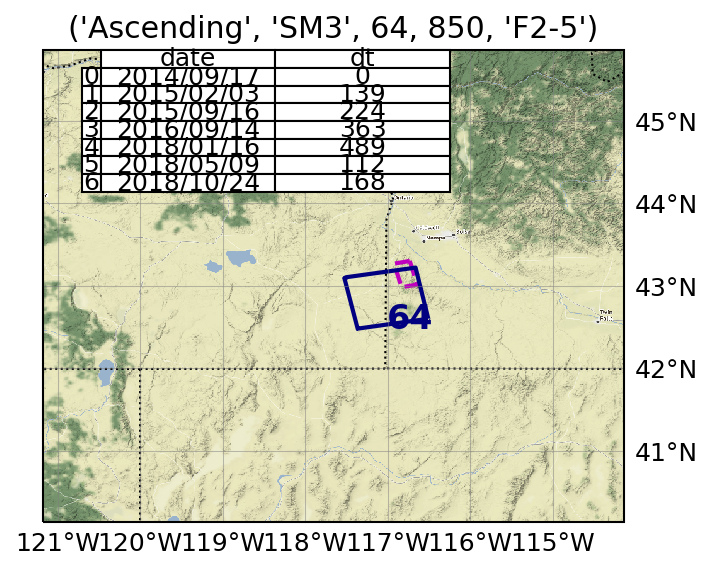

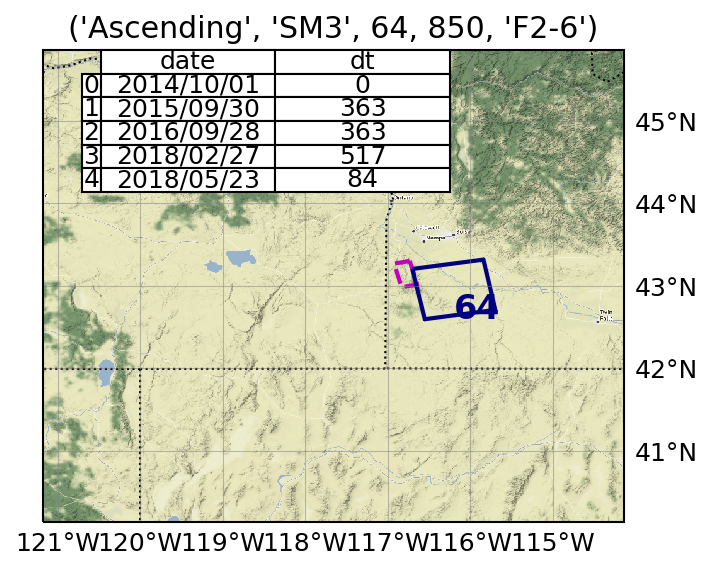

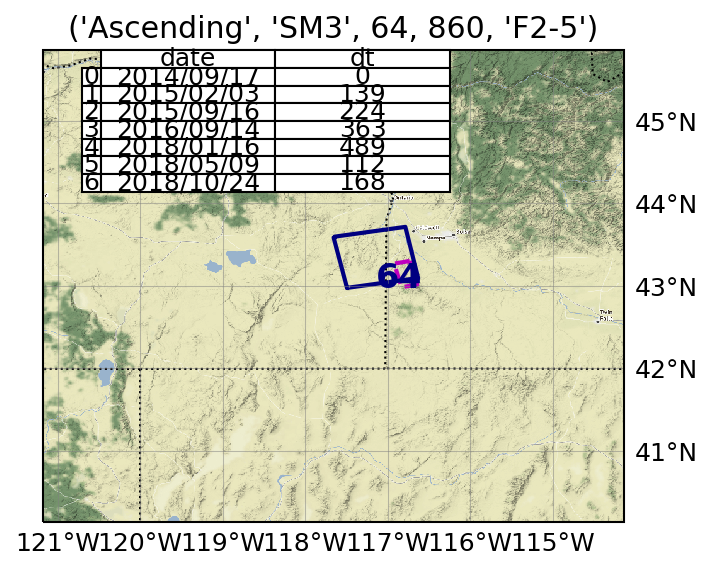

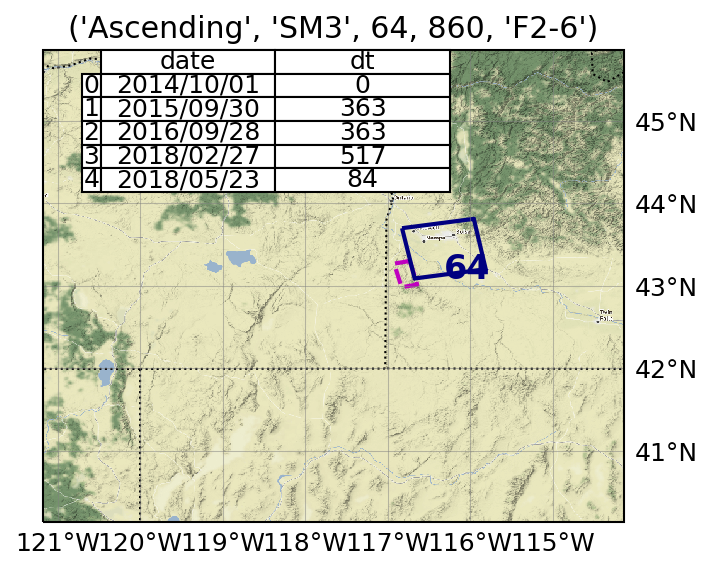

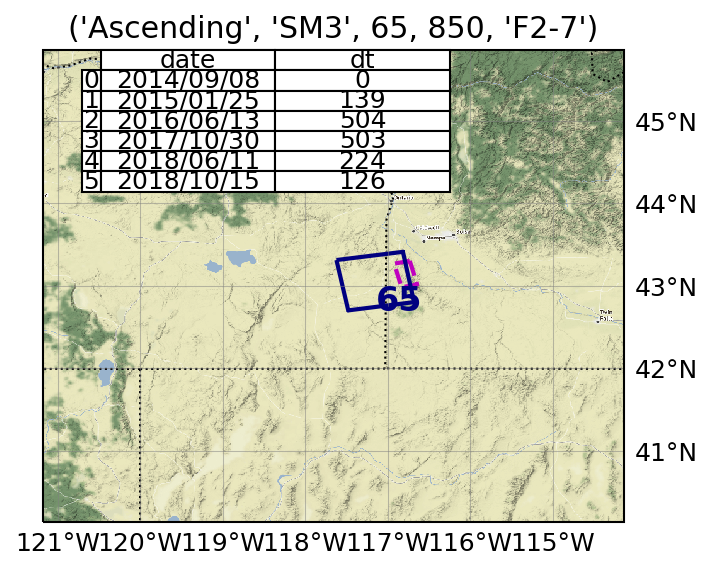

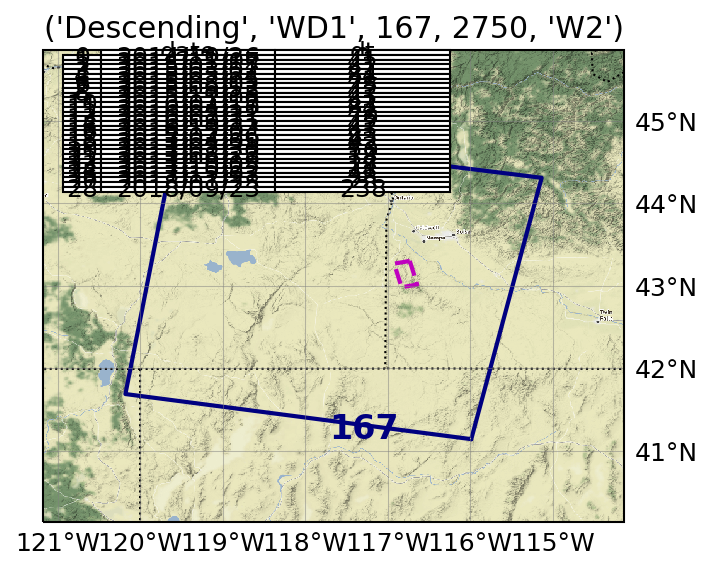

In [17]:
# Print maps for all combinations of possible interferometric pairs!
for labels, indices in GB.groups.items():
    #print(labels, indices)
    #print(labels, DF.loc[indices, "Scene ID"].tolist())
    inventory = GF.loc[indices]
    tmp = print_dates(inventory)
    plot_map(inventory, snwe, vectorFile, title=str(labels), tableFrame=tmp)

In [18]:
# Print out scene Ids in table for WD1
inventory

,sceneId,opMode,beamNo,relativeOrbit,frame,sceneDate,flightDirection,incidence,polarization,geometry
5,ALOS2023022750-141026,WD1,W2,167,2750,2014/10/26 12:57:12,Descending,34.9,HH+HV,POLYGON ((-119.5469970703125 44.85599899291992...
6,ALOS2029232750-141207,WD1,W2,167,2750,2014/12/07 11:57:12,Descending,34.9,HH+HV,POLYGON ((-119.5469970703125 44.85599899291992...
7,ALOS2035442750-150118,WD1,W2,167,2750,2015/01/18 11:57:12,Descending,34.9,HH+HV,POLYGON ((-119.5479965209961 44.85599899291992...
11,ALOS2041652750-150301,WD1,W2,167,2750,2015/03/01 11:57:11,Descending,34.9,HH+HV,POLYGON ((-119.5490036010742 44.85599899291992...
12,ALOS2054072750-150524,WD1,W2,167,2750,2015/05/24 12:57:08,Descending,34.9,HH+HV,POLYGON ((-119.5469970703125 44.85599899291992...
13,ALOS2060282750-150705,WD1,W2,167,2750,2015/07/05 12:57:07,Descending,34.9,HH+HV,POLYGON ((-119.5449981689453 44.85599899291992...
14,ALOS2064422750-150802,WD1,W2,167,2750,2015/08/02 12:57:07,Descending,34.9,HH+HV,POLYGON ((-119.5449981689453 44.85599899291992...
15,ALOS2070632750-150913,WD1,W2,167,2750,2015/09/13 12:57:07,Descending,34.9,HH+HV,POLYGON ((-119.5449981689453 44.85599899291992...
20,ALOS2076842750-151025,WD1,W2,167,2750,2015/10/25 12:57:07,Descending,34.9,HH+HV,POLYGON ((-119.5439987182617 44.85599899291992...
21,ALOS2083052750-151206,WD1,W2,167,2750,2015/12/06 11:57:08,Descending,34.9,HH+HV,POLYGON ((-119.5469970703125 44.85599899291992...


In [21]:
def print_inventory(GF):
    ''' print list of dates from dataframe'''
    tmp = GF.loc[:, ['sceneId','sceneDate']].reset_index(drop=True)
    tmp.loc[:, 'timeStamp'] = pd.to_datetime(tmp.sceneDate)
    tmp['date'] = tmp.sceneDate.str[:10]
    timeDeltas = tmp.timeStamp.diff()
    tmp['dt'] = timeDeltas.dt.days
    tmp.loc[0, 'dt'] = 0
    tmp['dt'] = tmp.dt.astype('i2')
    return tmp.loc[:, ['sceneId','date','dt']]

In [33]:
tmp = print_inventory(inventory)
tmp

,sceneId,date,dt
0,ALOS2023022750-141026,2014/10/26,0
1,ALOS2029232750-141207,2014/12/07,41
2,ALOS2035442750-150118,2015/01/18,42
3,ALOS2041652750-150301,2015/03/01,41
4,ALOS2054072750-150524,2015/05/24,84
5,ALOS2060282750-150705,2015/07/05,41
6,ALOS2064422750-150802,2015/08/02,28
7,ALOS2070632750-150913,2015/09/13,42
8,ALOS2076842750-151025,2015/10/25,42
9,ALOS2083052750-151206,2015/12/06,41


In [40]:
# print average revisit time (excluding 2018/09/23)
tmp.loc[0:27, 'dt'].mean()

42.25

In [24]:
for labels, indices in GB.groups.items():
    print(labels)

('Ascending', 'SM3', 64, 850, 'F2-5')
('Ascending', 'SM3', 64, 850, 'F2-6')
('Ascending', 'SM3', 64, 860, 'F2-5')
('Ascending', 'SM3', 64, 860, 'F2-6')
('Ascending', 'SM3', 65, 850, 'F2-7')
('Descending', 'WD1', 167, 2750, 'W2')


In [25]:
combos = [('Descending', 'WD1', 167, 2750, 'W2')]

for tup in combos:
    test = GB.get_group(tup)
    tmp = GF.loc[test.index]
    # save to shapefile
    name = '{}-{}-{}-{}.shp'.format(*tup)
    print(name)
    tmp.geometry.to_file(name)

Descending-WD1-167-2750.shp


In [42]:
name = '{}-{}-{}-{}.csv'.format(*tup)
print(name)
tmp.to_csv(name)

Descending-WD1-167-2750.csv


In [43]:
!head {name}

,sceneId,date,dt
0,ALOS2023022750-141026,2014/10/26,0
1,ALOS2029232750-141207,2014/12/07,41
2,ALOS2035442750-150118,2015/01/18,42
3,ALOS2041652750-150301,2015/03/01,41
4,ALOS2054072750-150524,2015/05/24,84
5,ALOS2060282750-150705,2015/07/05,41
6,ALOS2064422750-150802,2015/08/02,28
7,ALOS2070632750-150913,2015/09/13,42
8,ALOS2076842750-151025,2015/10/25,42


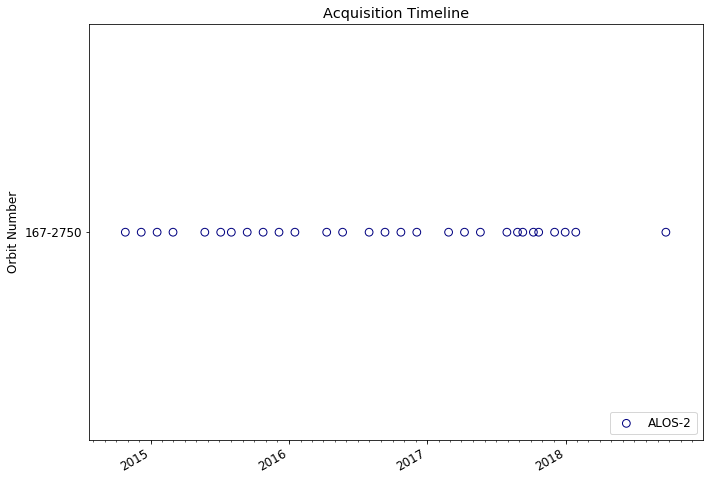

In [44]:
combos = [('Descending', 'WD1', 167, 2750, 'W2')]

for tup in combos:
    test = GB.get_group(tup)
    tmp = GF.loc[test.index]
    tmp = print_inventory(tmp)
    tmp['timeStamp'] = pd.to_datetime(tmp.date)
    tmp['orbitCode'] = 0
    tmp['relativeOrbit'] = '167-2750'
    plot_timeline(tmp)